<a href="https://colab.research.google.com/github/bosco-morales/CAP4767/blob/main/Module1_RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 1 - RFM Analysis
## Bosco M Morales - CAP4767-2243-4701 - Spring 2024

In [ ]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00


In [ ]:
#Import Libraries
import lifetimes
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Task 1 - Find a Suitable Dataset

The chosen data set is from Kaggle. You can view the data source here: https://www.kaggle.com/datasets/shedai/retail-data-set?resource=download

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/bosco-morales/CAP4767/main/CLV_Module%201/file_out2.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  29103 non-null  int64  
 1   InvoiceID   29103 non-null  int64  
 2   Date        29103 non-null  object 
 3   ProductID   29103 non-null  int64  
 4   TotalSales  29103 non-null  float64
 5   Discount    29103 non-null  float64
 6   CustomerID  29103 non-null  int64  
 7   Quantity    29103 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.8+ MB


For an RFM analysis the columns needed are the customer identifier, *CustomerID*, the customer total sales which in this case is *TotalSales* minus *Discount* and the transaction date in *Date*. All other columns are unnecessary for our analysis.


## Task 2 - Data Preparation:

Remove unnecessary columns

In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed: 0')]

In [ ]:
df = df.drop(['Quantity','ProductID','InvoiceID'], axis=1)

In [ ]:
#Verify that columns have been removed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        29103 non-null  object 
 1   TotalSales  29103 non-null  float64
 2   Discount    29103 non-null  float64
 3   CustomerID  29103 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 909.6+ KB


In [ ]:
df.describe()

,TotalSales,Discount,CustomerID
count,29103.000000,29103.000000,29103.000000
mean,2552.679147,451.325294,247.290279
std,4568.256400,650.359457,138.701207
min,0.000000,-0.004694,0.000000
25%,779.661017,137.288136,134.000000
50%,1366.101695,244.067797,230.000000
75%,2847.457627,508.658644,349.000000
max,332574.460000,14110.169492,506.000000


For our analysis we consider removing TotalSales that are zero as they do not add any value to our analysis.

In [ ]:
df = df[df['TotalSales'] > 0 ] # Exclude sales with 0 value

In [ ]:
#Checking for null values
df.isnull().sum()

Date          0
TotalSales    0
Discount      0
CustomerID    0
dtype: int64

Look for outliers




In [ ]:
df.describe()

,TotalSales,Discount,CustomerID
count,28927.000000,28927.000000,28927.000000
mean,2568.210364,454.071284,247.371349
std,4577.778367,651.378574,138.797156
min,0.010000,-0.004694,0.000000
25%,782.627119,139.118644,134.000000
50%,1383.050847,244.067797,230.000000
75%,2881.355932,512.542373,349.000000
max,332574.460000,14110.169492,506.000000


Treat outliers for TotalSales and Discount

In [ ]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):
    # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary
def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [ ]:
capping_outliers(df,'TotalSales')
capping_outliers(df,'Discount')

In [ ]:
df.describe()

,TotalSales,Discount,CustomerID
count,28927.000000,28927.000000,28927.000000
mean,2253.276431,402.476604,247.371349
std,2173.972478,391.467844,138.797156
min,338.983051,56.440678,0.000000
25%,782.627119,139.118644,134.000000
50%,1383.050847,244.067797,230.000000
75%,2881.355932,512.542373,349.000000
max,8474.576271,1525.112542,506.000000


## Task 3 - RFM Analysis:

Here NetTotal represents the actual dollar amount of the sale after deducting any discounts.

In [ ]:
df['NetTotal'] = df['TotalSales'] - df['Discount']

In [ ]:
df.columns

Index(['Date', 'TotalSales', 'Discount', 'CustomerID', 'NetTotal'], dtype='object')

In [ ]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','Date','NetTotal',observation_period_end='2023-03-25')

In [ ]:
clv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 506
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       507 non-null    float64
 1   recency         507 non-null    float64
 2   T               507 non-null    float64
 3   monetary_value  507 non-null    float64
dtypes: float64(4)
memory usage: 19.8 KB


In [ ]:
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
0,26.0,427.0,434.0,7504.538057
1,12.0,761.0,1496.0,1390.007175
2,21.0,1324.0,1376.0,1709.134576
3,0.0,0.0,625.0,0.000000
4,34.0,1443.0,1535.0,1454.299432


In [ ]:
# let's filter so that we only catch customers who have made more than 1 purchase
clv = clv[clv['frequency']>1]

In [ ]:
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
0,26.0,427.0,434.0,7504.538057
1,12.0,761.0,1496.0,1390.007175
2,21.0,1324.0,1376.0,1709.134576
4,34.0,1443.0,1535.0,1454.299432
10,33.0,652.0,667.0,4517.527103


## Task 4 - Customer Segmentation:

### BG/NBD Model


In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.001)  # This will allow you to predict FUTURE purchase by taking into account F, R, T  penalizer is used to avoid overfitting
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 271 subjects, a: 0.13, alpha: 15.43, b: 3.67, r: 0.93>

In [ ]:
t = 180 # 6 month/180 day period
clv['expected_purch_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])

# round to two decimal places
pd.options.display.float_format = '{:.2f}'.format

clv.sort_values(by='expected_purch_6_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purch_6_months
CustomerID,,,,,
233,89.00,127.00,127.00,10559.90,107.22
230,633.00,1543.00,1543.00,5761.67,72.70
231,78.00,266.00,266.00,4668.39,48.78
420,379.00,1530.00,1533.00,4702.34,43.83
424,379.00,1533.00,1538.00,1974.22,43.67


### Gamma-Gamma Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.00,0.17
monetary_value,0.17,1.00


In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 271 subjects, p: 3.09, q: 0.19, v: 3.07>

In [ ]:
# round to two decimal places
pd.options.display.float_format = '{:.2f}'.format


In [ ]:
clv['six_months_clv']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)
clv.sort_values('six_months_clv',ascending=False).head()



,frequency,recency,T,monetary_value,expected_purch_6_months,six_months_clv
CustomerID,,,,,,
233,89.00,127.00,127.00,10559.90,107.22,1097339.13
230,633.00,1543.00,1543.00,5761.67,72.70,404772.52
231,78.00,266.00,266.00,4668.39,48.78,220758.40
57,269.00,1537.00,1541.00,6843.57,30.97,204950.23
420,379.00,1530.00,1533.00,4702.34,43.83,199218.68


In [ ]:
clv['segment'] =  pd.qcut(clv['six_months_clv'],4,labels = ['Hibernating','Need Attention', 'Loyal Customers', 'Champions'])

In [ ]:
clv.head()

,frequency,recency,T,monetary_value,expected_purch_6_months,six_months_clv,segment
CustomerID,,,,,,,
0,26.00,427.00,434.00,7504.54,10.49,76838.61,Champions
1,12.00,761.00,1496.00,1390.01,0.03,43.60,Hibernating
2,21.00,1324.00,1376.00,1709.13,2.78,4652.33,Need Attention
4,34.00,1443.00,1535.00,1454.30,3.91,5542.39,Need Attention
10,33.00,652.00,667.00,4517.53,8.76,38514.29,Champions


In [ ]:
clv.groupby('segment').mean()

,frequency,recency,T,monetary_value,expected_purch_6_months,six_months_clv
segment,,,,,,
Hibernating,26.00,543.21,1365.18,1370.53,0.07,71.95
Need Attention,15.69,1067.38,1229.03,2412.83,1.53,3276.50
Loyal Customers,59.45,1194.67,1230.28,2688.32,7.50,16703.52
Champions,152.09,1193.07,1203.19,4231.41,22.27,94736.23


In [ ]:
clv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 506
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   frequency                271 non-null    float64 
 1   recency                  271 non-null    float64 
 2   T                        271 non-null    float64 
 3   monetary_value           271 non-null    float64 
 4   expected_purch_6_months  271 non-null    float64 
 5   six_months_clv           271 non-null    float64 
 6   segment                  271 non-null    category
dtypes: category(1), float64(6)
memory usage: 15.3 KB


## Task 5 - Visualizations

### Top 5 Customers by Monetary Value

In [ ]:
# Filtering out Top/Best cusotmers
top_5 = clv.sort_values('monetary_value', ascending=False).head()

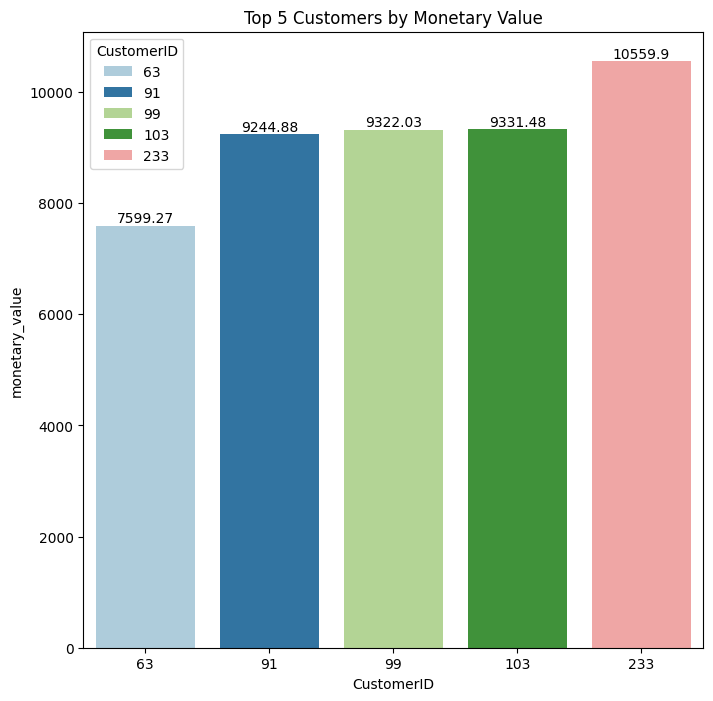

In [ ]:
# Setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(8, 8))

top_5_viz = sns.barplot(top_5, x='CustomerID', y= 'monetary_value', hue ='CustomerID', palette='Paired', errwidth=0,ax=ax)

# Adding title
top_5_viz.set_title('Top 5 Customers by Monetary Value')

# Adding data label to bars
for i in top_5_viz.containers:
    top_5_viz.bar_label(i,)

### Number of Customers per Segment

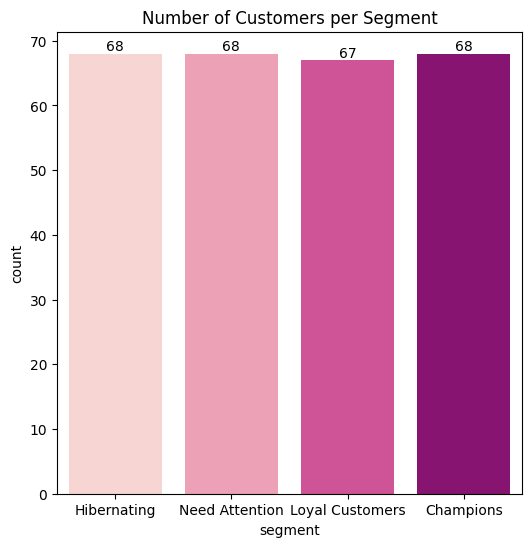

In [ ]:
# Setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(6, 6))

segment_counts_viz = sns.countplot(clv, x='segment', hue='segment', ax=ax, palette='RdPu')

# Adding title
segment_counts_viz.set_title('Number of Customers per Segment')

#Add data label to bars
for i in segment_counts_viz.containers:
    segment_counts_viz.bar_label(i,)


### Average Six-Month CLV per Segment

Text(0.5, 1.0, 'Average Six-Month CLV per Segment')

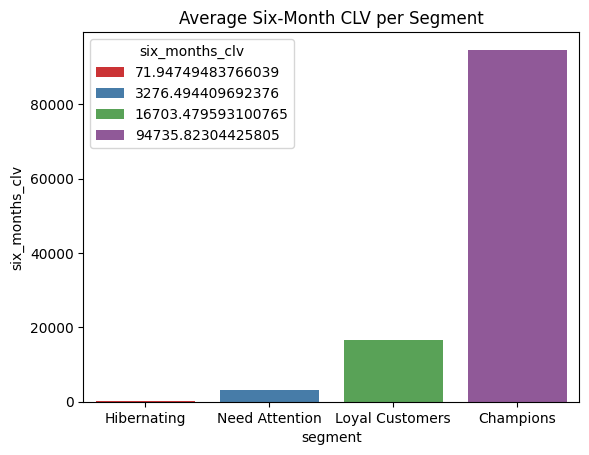

In [ ]:
clv_by_segment = clv.groupby('segment')['six_months_clv'].mean().reset_index()

average_clv_viz = sns.barplot(clv_by_segment, x= 'segment', y='six_months_clv', hue = 'six_months_clv', palette='Set1')

# Adding title
average_clv_viz.set_title('Average Six-Month CLV per Segment')

### Percentage of Monetary Value (sum) per Segment

Text(0.5, 1.0, 'Percentage of Monetary Value (sum) per Segment')

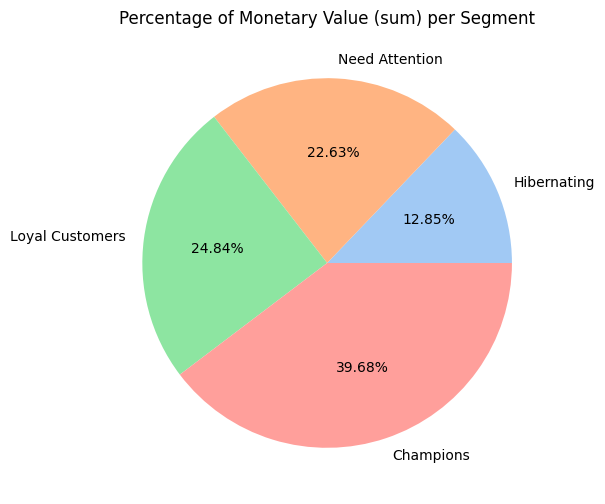

In [ ]:
monetaryvalue_per_segment = clv.groupby('segment')['monetary_value'].sum().reset_index()
fig, ax = plt.subplots(figsize = (8,6))

# define Seaborn color palette to use
palette_color = sns.color_palette('pastel')

plt.pie(monetaryvalue_per_segment['monetary_value'], labels=monetaryvalue_per_segment['segment'], autopct='%1.2f%%', colors=palette_color)

# Adding title
plt.title("Percentage of Monetary Value (sum) per Segment")